In [1]:
# Import libraries
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
import matplotlib.pyplot as plt

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

# Load and preprocess the data
start = dt.datetime(2021, 7, 1)
end = dt.datetime(2021, 12, 28)

# Load the CSV file and filter data by date
data = pd.read_csv('Tatacoffee13_21.csv', parse_dates=['Date'], index_col='Date')

# Ensure the data is between the start and end dates
data = data[(data.index >= start) & (data.index <= end)]

# Select specific columns for modeling
stk_data = data[['Open', 'High', 'Low', 'Close']]


In [3]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
data1= Ms.fit_transform(stk_data)
print("Len:",data1.shape)

Len: (123, 4)


In [4]:
data1=pd.DataFrame(data1,columns=["Open","High","Low","Close"])
data1

,Open,High,Low,Close
0,0.111864,0.022422,0.083571,0.052680
1,0.017797,0.000000,0.067426,0.086876
2,0.099153,0.162182,0.175689,0.198706
3,0.200000,0.109118,0.166192,0.131238
4,0.098305,0.096413,0.129155,0.206100
...,...,...,...,...
118,0.354237,0.303438,0.432099,0.430684
119,0.406780,0.289238,0.445394,0.392791
120,0.371186,0.245142,0.394112,0.356747
121,0.305085,0.515695,0.330484,0.677449


In [5]:
training_size = round(len(data1 ) * 0.80)
print(training_size)
X_train=data1[:training_size]
X_test=data1[training_size:]
print("X_train length:",X_train.shape)
print("X_test length:",X_test.shape)
y_train=data1[:training_size]
y_test=data1[training_size:]
print("y_train length:",y_train.shape)
print("y_test length:",y_test.shape)

98
X_train length: (98, 4)
X_test length: (25, 4)
y_train length: (98, 4)
y_test length: (25, 4)


In [10]:
# Define the combination_varma function
def combination_varma(dataset, listt):
    print("Columns selected:", listt)
    
    # Extract the selected columns
    dataset_two = dataset[listt]
    test_obs = 28
    train = dataset_two[:-test_obs]
    test = dataset_two[-test_obs:]

    # Initialize performance dictionary
    performance = {"Model": [], "RMSE": [], "MaPe": [], "Lag": [], "Test": []}

    best_aic = float("inf")
    best_order = None
    best_model = None

    # Iterate through different (p, q) combinations to find the best model
    for p in range(1, 4):  # AR order range, adjust as needed
        for q in range(0, 3):  # MA order range, adjust as needed
            print(f"Trying order = ({p}, {q})")
            try:
                model = VARMAX(train, order=(p, q))
                results = model.fit(disp=False)
                print(f"Order = ({p}, {q}), AIC = {results.aic}, BIC = {results.bic}")

                # Track the best model based on AIC
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, q)
                    best_model = results
            except Exception as e:
                print(f"Failed for order ({p}, {q}): {e}")

    print(f"\nBest Order: {best_order}, AIC: {best_aic}")
    
    # Fit the final model with the best order
    final_model = VARMA(train, order=best_order)
    result = final_model.fit(disp=False)
    

    # Forecast for the test period
    lagged_values = train.values[-best_order[0]:]
    pred = result.forecast(steps=test_obs, y=lagged_values)
    
    # Convert predictions back to a DataFrame
    preds = pd.DataFrame(pred, columns=listt)
    preds.to_csv(f"varma_forecasted_{test_obs}.csv")
    
    # Inverse transform predictions
    pred_original = Ms.inverse_transform(pred)
    pred_original_df = pd.DataFrame(pred_original, columns=listt)
    
    # Evaluate performance
    rmse = round(mean_squared_error(test, pred, squared=False), 2)
    mape = mean_absolute_percentage_error(test, pred)
    
    # Save performance metrics
    performance["Model"].append(listt)
    performance["RMSE"].append(rmse)
    performance["MaPe"].append(mape)
    performance["Lag"].append(best_order)
    performance["Test"].append(test_obs)

    # Convert performance metrics to DataFrame
    perf = pd.DataFrame(performance)
    # Save predictions to CSV
    preds.to_csv("varma_forecasted_{}.csv".format(test_obs))
    
    print("\nPerformance Metrics:")
    print(f"RMSE: {rmse}, MAPE: {mape}")
    
    return perf, result, preds, pred_original_df

# Define the column list and call the function
listt = ["Open", "High", "Low", "Close"]
perf, result, preds, pred_original_df = combination_varma(data1, listt)

# Performance summary
print("\nPerformance Summary:")
print(perf)

# Model summary
print("\nModel Summary:")
print(result.summary())

# Display the first few rows of the predicted values
print("\nScale values:")
print(preds.head())

# Display the original predictions
print("\nOriginal  Predictions:")
print(pred_original_df.head())


Columns selected: ['Open', 'High', 'Low', 'Close']
Trying order = (1, 0)
Order = (1, 0), AIC = -1249.5054772886788, BIC = -1172.8891705406625
Trying order = (1, 1)
Order = (1, 1), AIC = -1220.7565481547113, BIC = -1103.2782111410863
Trying order = (1, 2)
Order = (1, 2), AIC = -1200.6242608761058, BIC = -1042.2838935968723
Trying order = (2, 0)
Order = (2, 0), AIC = -1229.924997829501, BIC = -1112.4466608158762
Trying order = (2, 1)
Failed for order (2, 1): Schur decomposition solver error.
Trying order = (2, 2)
Order = (2, 2), AIC = -1172.8659844120439, BIC = -973.6635868672017
Trying order = (3, 0)
Order = (3, 0), AIC = -1208.9000558300563, BIC = -1050.5596885508228
Trying order = (3, 1)
Order = (3, 1), AIC = -1176.9894373231505, BIC = -977.7870397783083
Trying order = (3, 2)
Order = (3, 2), AIC = -1148.22768674495, BIC = -908.1632589344993

Best Order: (1, 0), AIC: -1249.5054772886788

Performance Metrics:
RMSE: 0.16, MAPE: 0.33956071989424624

Performance Summary:
                  

In [9]:
perf

,Model,RMSE,MaPe,Lag,Test
0,"[Open, High, Low, Close]",0.16,0.339561,"(1, 0)",28


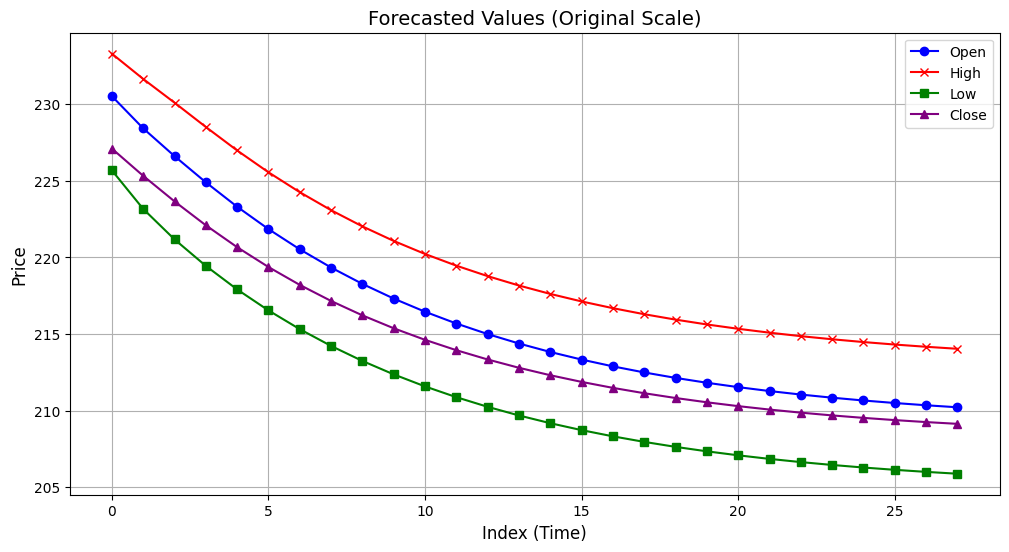

In [11]:
import matplotlib.pyplot as plt

# Plotting the predictions on the original scale
plt.figure(figsize=(12, 6))

# Plot each of the variables (Open, High, Low, Close)
plt.plot(pred_original_df.index, pred_original_df['Open'], label='Open', color='blue', marker='o')
plt.plot(pred_original_df.index, pred_original_df['High'], label='High', color='red', marker='x')
plt.plot(pred_original_df.index, pred_original_df['Low'], label='Low', color='green', marker='s')
plt.plot(pred_original_df.index, pred_original_df['Close'], label='Close', color='purple', marker='^')

# Adding labels and title
plt.title('Forecasted Varma', fontsize=14)
plt.xlabel('Index (Time)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='best')

# Display the plot
plt.grid(True)
plt.show()

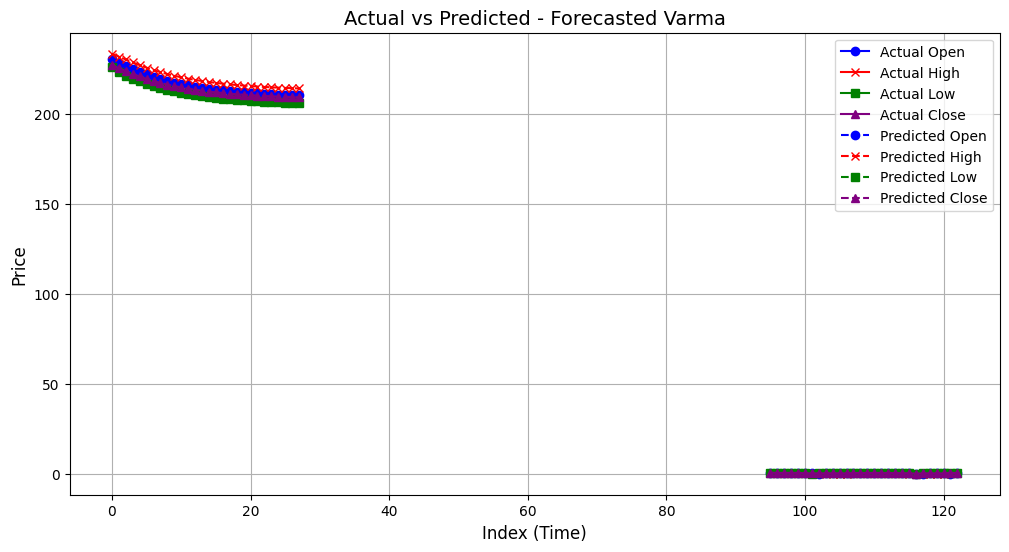

In [33]:
import matplotlib.pyplot as plt

# Assuming your actual stock data is in 'data1' and your predicted data is in 'pred_original_df'

# Extract the last 'test_obs' rows from 'data1' (for actual values)
test_obs = 28  # Example: last 28 rows for test data
actual_stock_price_test = data1[-test_obs:]

# Plotting the actual and predicted values on the original scale
plt.figure(figsize=(12, 6))

# Plot the actual data (using actual_stock_price_test)
plt.plot(actual_stock_price_test.index, actual_stock_price_test['Open'], label='Actual Open', color='blue', linestyle='-', marker='o')
plt.plot(actual_stock_price_test.index, actual_stock_price_test['High'], label='Actual High', color='red', linestyle='-', marker='x')
plt.plot(actual_stock_price_test.index, actual_stock_price_test['Low'], label='Actual Low', color='green', linestyle='-', marker='s')
plt.plot(actual_stock_price_test.index, actual_stock_price_test['Close'], label='Actual Close', color='purple', linestyle='-', marker='^')

# Plot the predicted data (from pred_original_df)
plt.plot(pred_original_df.index, pred_original_df['Open'], label='Predicted Open', color='blue', linestyle='--', marker='o')
plt.plot(pred_original_df.index, pred_original_df['High'], label='Predicted High', color='red', linestyle='--', marker='x')
plt.plot(pred_original_df.index, pred_original_df['Low'], label='Predicted Low', color='green', linestyle='--', marker='s')
plt.plot(pred_original_df.index, pred_original_df['Close'], label='Predicted Close', color='purple', linestyle='--', marker='^')

# Adding labels and title
plt.title('Actual vs Predicted - Forecasted Varma', fontsize=14)
plt.xlabel('Index (Time)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='best')

# Display the plot
plt.grid(True)
plt.show()